In [1]:
!pip install keras


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import LSTM,Dense
from datetime import datetime, timedelta
from kerastuner import RandomSearch
from keras.metrics import MeanAbsolutePercentageError,RootMeanSquaredError
from keras_tuner import HyperModel
from keras_tuner import HyperParameters as hp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
import seaborn as sns
import pytz #tratar zona hoaria de los datos

<ipython-input-3-dd6e6e0c7386>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


http://www.scielo.org.co/scielo.php?script=sci_arttext&pid=S0120-56092007000300012

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import os
os.environ['Kaggle_config_dir']='/content/gdrive/MyDrive/Colab Notebooks/Kaggle'#

In [7]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Kaggle

/content/gdrive/MyDrive/Colab Notebooks/Kaggle


In [8]:
#!ls

In [9]:
class MyHypermodel(HyperModel):
  def __init__(self,entrada,salida):
    self.entrada=entrada
    self.salida=salida
  def build(self,hp):
    modelo=Sequential()
    modelo.add(LSTM(units=hp.Int('units_1',80,160,step=40),input_shape=self.entrada,return_sequences=True))
    modelo.add(LSTM(units=hp.Int('units_2',160,320,step=40),return_sequences=True))
    modelo.add(LSTM(units=hp.Int('units_3',640,720,step=40))) 
    modelo.add(Dropout(rate=hp.Float('r',0.09,0.2,step=0.025)))
    modelo.add(Dense(units=self.salida))
    modelo.compile(optimizer='adam',loss='mse',metrics=[RootMeanSquaredError(name='mse')])
    return modelo
    
  def fit(self,hp,modelo,*args,**kwargs):
    return modelo.fit(*args,validation_split=0.27, epochs=hp.Choice('epocas',[200,500,1000,1500]),batch_size=35,**kwargs)


#Serie con red neuronal

In [10]:
fed=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/FRB_H15.csv')

In [11]:
fed.drop(0,axis=0,inplace=True)

In [12]:
fed.rename(columns={'H15/H15/RIFSPFF_N.WW':'R_US'},inplace=True)

In [13]:
fed.rename(columns={'Unique Identifier: ':'Fecha'},inplace=True)

In [14]:
tz=pytz.timezone('US/Eastern')

In [15]:
fed['Fecha']=pd.to_datetime(fed['Fecha'],utc=tz)

In [16]:
fed['R_US']=fed['R_US'].astype(float)

In [17]:
fed.set_index('Fecha',inplace=True)

In [18]:
fed.index

DatetimeIndex(['2010-01-06 00:00:00+00:00', '2010-01-13 00:00:00+00:00',
               '2010-01-20 00:00:00+00:00', '2010-01-27 00:00:00+00:00',
               '2010-02-03 00:00:00+00:00', '2010-02-10 00:00:00+00:00',
               '2010-02-17 00:00:00+00:00', '2010-02-24 00:00:00+00:00',
               '2010-03-03 00:00:00+00:00', '2010-03-10 00:00:00+00:00',
               ...
               '2023-03-08 00:00:00+00:00', '2023-03-15 00:00:00+00:00',
               '2023-03-22 00:00:00+00:00', '2023-03-29 00:00:00+00:00',
               '2023-04-05 00:00:00+00:00', '2023-04-12 00:00:00+00:00',
               '2023-04-19 00:00:00+00:00', '2023-04-26 00:00:00+00:00',
               '2023-05-03 00:00:00+00:00', '2023-05-10 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Fecha', length=697, freq=None)

In [19]:
#pytz.common_timezones[:]

In [20]:
fed=fed.asfreq('D',method='bfill').tz_convert('America/Bogota')

In [21]:
fed.index=pd.to_datetime(fed.index.strftime('%Y-%m-%d'))

In [22]:
fed.tail()

,R_US,H15/H15/RIFSPBLP_N.WW,H15/H15/RIFSRP_F02_N.WW
Fecha,,,
2023-05-05,5.08,8.25,5.25
2023-05-06,5.08,8.25,5.25
2023-05-07,5.08,8.25,5.25
2023-05-08,5.08,8.25,5.25
2023-05-09,5.08,8.25,5.25


In [23]:
del fed['H15/H15/RIFSPBLP_N.WW']
del fed['H15/H15/RIFSRP_F02_N.WW']


In [24]:
dolar_y=pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/trm6.csv',sep=';')

In [25]:
dolar_y['Fecha']=pd.to_datetime(dolar_y['Fecha'])

In [26]:
dolar_y['COP/USD']=dolar_y['COP/USD'].replace(',','.',regex=True)

In [27]:
dolar_y['COP/USD']=dolar_y['COP/USD'].astype(float)

In [28]:
dolar_y.head()

,Fecha,COP/USD
0,1991-11-27,693.32
1,1991-11-28,693.99
2,1991-11-29,694.70
3,1991-11-30,694.70
4,1991-12-01,643.42


In [29]:
dolar_y=dolar_y.drop_duplicates()

In [30]:
dolar_y['anios']=dolar_y['Fecha'].dt.year

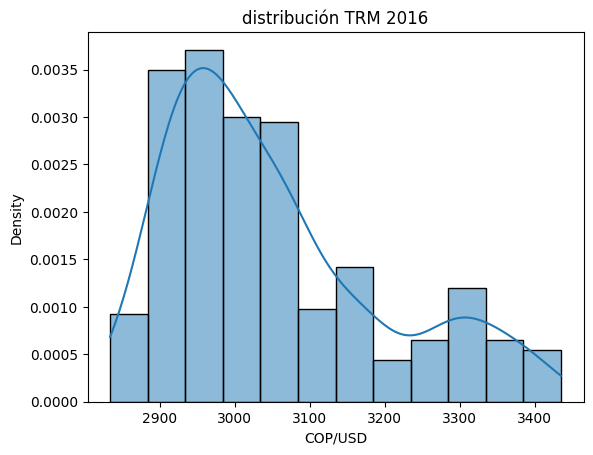

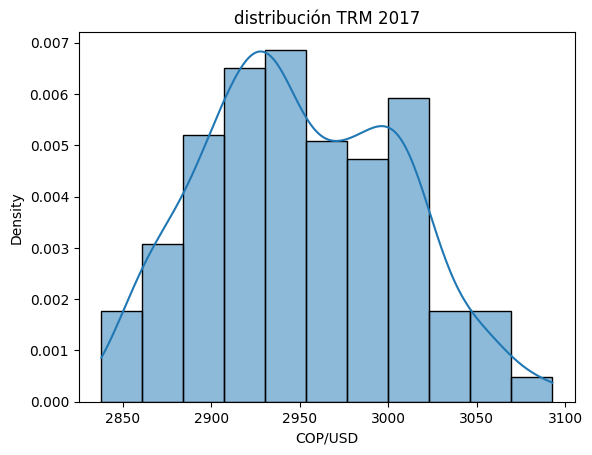

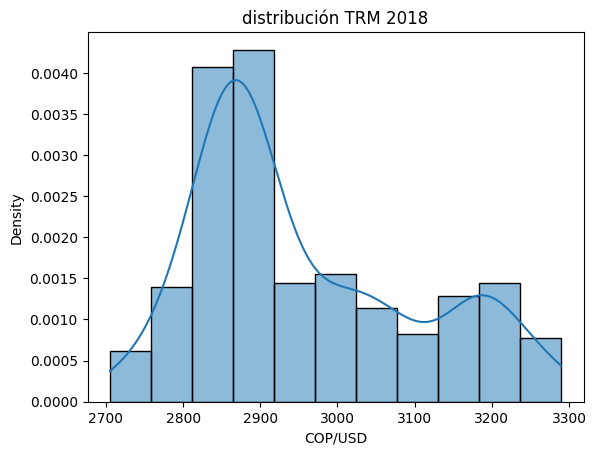

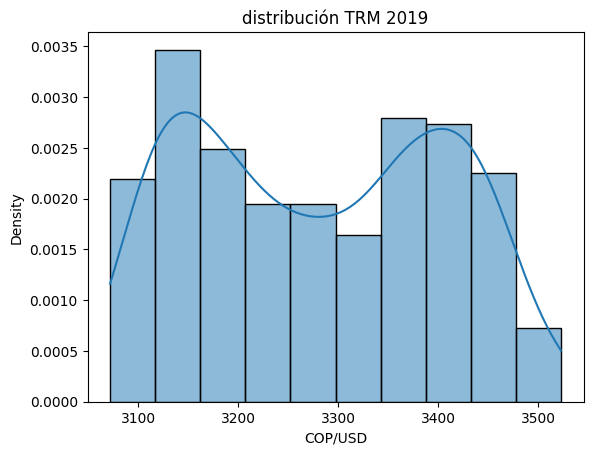

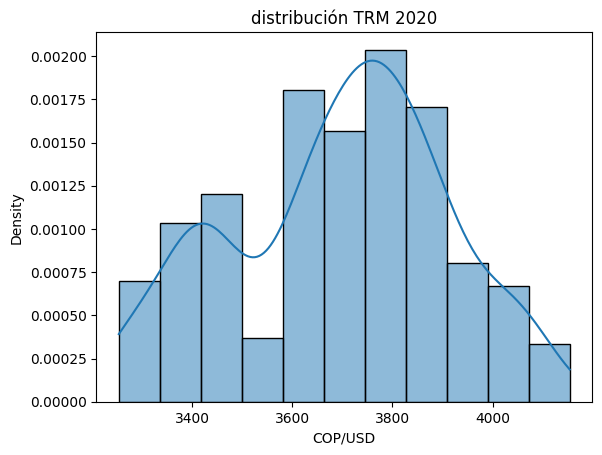

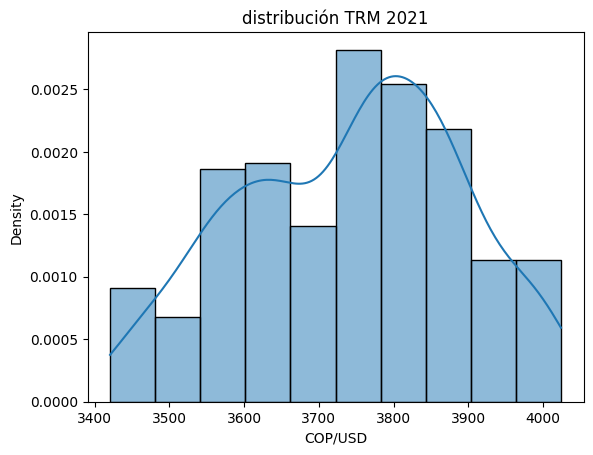

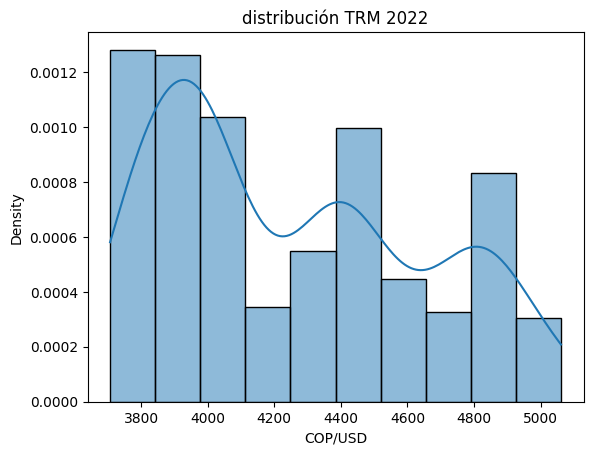

In [31]:
for i in [2016,2017,2018,2019,2020,2021,2022]:
  fig,ax=plt.subplots()
  datos_graf=dolar_y[dolar_y['anios']==i]
  sns.histplot(data=datos_graf,x='COP/USD',kde=True,stat='density',ax=ax)
  plt.title(f'distribución TRM {i}')

In [32]:
datos=dolar_y[dolar_y['anios']>=2016]

In [33]:
datos.head()

,Fecha,COP/USD,anios
8801,2016-01-01,3149.47,2016
8802,2016-01-02,3149.47,2016
8803,2016-01-03,3149.47,2016
8804,2016-01-04,3149.47,2016
8805,2016-01-05,3213.24,2016


In [34]:
datos.set_index('Fecha',inplace=True)

In [35]:
datos=datos.merge(fed,how='left',on='Fecha')

In [36]:
datos.sort_index(inplace=True)

In [37]:
#datos['COP/USD']=datos['COP/USD'].interpolate(method='linear')
datos=datos.asfreq('D',method='bfill')

In [38]:
datos.isna().sum()

COP/USD    0
anios      0
R_US       6
dtype: int64

In [39]:
datos['R_US']=datos['R_US'].asfreq('D',method='bfill')

In [40]:
del datos['anios']

In [41]:
datos.fillna(5.08,inplace=True)

In [42]:
#datos['Dia']=datos.index.tz_localize(pytz.timezone('America/Bogota')).strftime('%w')

In [43]:
#datos['Dia']=datos['Dia'].astype(int)

In [44]:
datos.dtypes

COP/USD    float64
R_US       float64
dtype: object

In [45]:
normalizador=MinMaxScaler(feature_range=(0,1))

In [46]:
datos['R_US']=datos['R_US'].apply(lambda x:x/100)

In [47]:
normalizador.fit(datos[['COP/USD']])

MinMaxScaler()

In [48]:
datos[['COP/USD']]=normalizador.transform(datos[['COP/USD']])

In [49]:
def particion_datos(datos,train='2023-02-21',test='2023-02-22'): #,val=0.1,
  total=datos.shape[0] 
  train=datos[datos.index<='2023-02-21']
  test=datos[(datos.index>='2023-02-22')&(datos.index<'2023-05-15')]
  return train,test

In [50]:
train,test=particion_datos(datos)

In [51]:
def config_serie(datos,lags,steps):
  x,y=[],[]
  shape=datos.shape
  fila,col=datos.shape   
  for i in range(fila-lags-steps+1):
    x.append(datos.iloc[i:i+lags,:])
    y.append(datos.iloc[i+lags:i+lags+steps,0])
  X=np.array(x)
  Y=np.array(y)
  return X,Y

In [52]:
len(test)

82

In [53]:
x_train,y_train=config_serie(train,8,3)

In [54]:
x_test,y_test=config_serie(test,8,3)#los y_test inician  desde el 29/03/2023, desde el 22/02/2023 hasta el 29/03/2023 va los x_train

In [55]:
hipmod=MyHypermodel((x_train.shape[1],2),y_train.shape[1])

In [56]:
tuner=RandomSearch(hipmod,objective=('val_mse'),max_trials=1, directory='busqueda_red_neuronal',project_name='TRM_I-US30')# SerieV 2013,SerieVer1 sin tasa de interes 35,5


'TRM_I-US2'  35 pesos dia, 54 dias- 3 dias 2016

'TRM_I-US30'  33 pesos dia, 8 dias- 3 dias 2016

In [57]:
x_train.shape

(2599, 8, 2)

In [58]:
y_train.shape

(2599, 3)

Mejores modelos han sido modelV1 modelVA

In [59]:
tuner.search(x_train,y_train)

In [60]:
tuner.results_summary()

Results summary
Results in busqueda_red_neuronal/TRM_I-US30
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 0 summary
Hyperparameters:
units_1: 160
units_2: 280
units_3: 720
r: 0.09
epocas: 200
Score: 0.020228294655680656


In [61]:
mod=tuner.get_best_models(num_models=1)[0]

In [134]:
def test_mod(modelo,x_test,y_test,normalizador):
  dolar_prediccion=modelo.predict(x_test)
  y_test=normalizador.inverse_transform(y_test)
  dolar_prediccion=normalizador.inverse_transform(dolar_prediccion)
  adT=y_test[-1,[1,2]]
  adP=dolar_prediccion[-1,[1,2]]
  adT=np.reshape(adT,(2,1))
  adP=np.reshape(adP,(2,1))
  a1=pd.DataFrame(adP,columns=['TRM Modelo'])
  b1=pd.DataFrame(adT,columns=['TRM Real'])
  ab=pd.concat([a1,b1],axis=1)
  y_m=y_test[:,:]
  d_m=dolar_prediccion[:,:]
  #error entre prededicicones
  div=np.square(y_m-d_m)
  div=np.mean(div,axis=0)
  div=np.sqrt(div)
  fig,ax=plt.subplots()
  
  ax.plot(div,'o--')
  ax.set_xlabel('Dia')
  ax.set_ylabel('Error ($)')
  ax.set_xticks([0,1,2],labels=['D1','D2','D3'])
  y_test=y_test[:,[0]]
  dolar_prediccion=dolar_prediccion[:,[0]]
  a=pd.DataFrame(dolar_prediccion,columns=['TRM Modelo'])
  b=pd.DataFrame(y_test,columns=['TRM Real'])
  RvsM=pd.concat([a,b],axis=1)
  RvsM=pd.concat([RvsM,ab],axis=0,ignore_index=False)
  end=datos.index[-2]
  st=end-timedelta(len(RvsM)-1)
  fecha_test=pd.date_range(start=st,end=end,freq='D')
  RvsM.index=fecha_test
  metrica=mean_squared_error(y_m,d_m,squared=False)
  return RvsM,metrica,ax,div


3/3 [==============================] - 0s 54ms/step


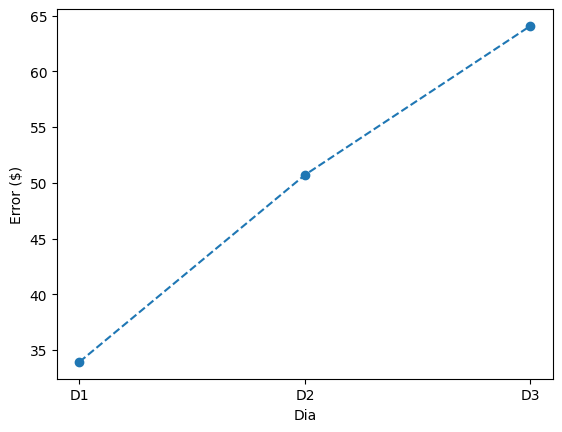

In [135]:
RvsM,mt,grafico,errores=test_mod(mod,x_test,y_test,normalizador)

In [133]:
errores

array([33.92689635, 50.70285051, 64.07287709])

In [69]:
def pronostico_actual(datos,modelo):
  d=datos.iloc[-9:-1,:]
  x_act=np.array([d]).reshape(1,8,2)
  pronost=modelo.predict(x_act)
  pronost=normalizador.inverse_transform(pronost)
  s=datos.iloc[-9:-1,0].index[-1]  
  ini=s+timedelta(1)
  fin=ini+timedelta(2)
  fechas=pd.date_range(start=ini,end=fin,freq='D')
  pronost=pd.DataFrame(pronost[0],columns=['TRM M'],index=fechas)#
  return pronost

In [70]:
semana=pronostico_actual(datos,mod)

1/1 [==============================] - 0s 49ms/step


In [71]:
semana

,TRM M
2023-05-15,4570.237305
2023-05-16,4566.282715
2023-05-17,4573.125488


In [72]:
x_train.shape

(2599, 8, 2)

In [73]:
tendencia=pd.concat([RvsM['TRM Modelo'],semana['TRM M']],axis=0,ignore_index=False)

In [74]:
tendencia

2023-03-02    4807.992188
2023-03-03    4841.502441
2023-03-04    4847.536133
2023-03-05    4767.608887
2023-03-06    4775.246094
                 ...     
2023-05-13    4541.272461
2023-05-14    4548.698730
2023-05-15    4570.237305
2023-05-16    4566.282715
2023-05-17    4573.125488
Freq: D, Length: 77, dtype: float32

In [75]:
import plotly.express as pg

In [76]:
pg.line(x=RvsM.index,y=[RvsM['TRM Modelo'],RvsM['TRM Real']])

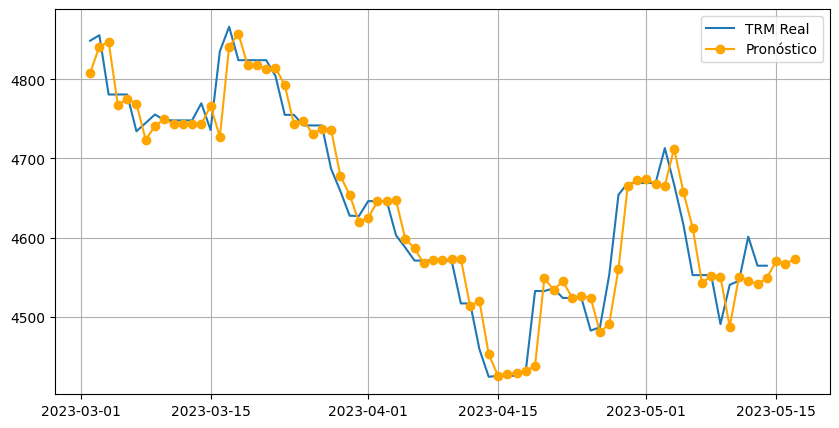

In [77]:
plt.figure(figsize=(10,5))
plt.plot(RvsM.loc[:,'TRM Real'],label='TRM Real')
#plt.scatter(x=RvsM.index,y=RvsM.loc[:,'TRM Modelo'],label='TRM Modelo',marker='o',color='orange')
plt.plot(tendencia,label='Pronóstico',marker='o',color='orange')
#plt.title('TRM_Modelo')
plt.legend()
plt.grid()
plt.show()
#plt.savefig('grafico.png')

In [78]:
with pd.ExcelWriter('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/Real_modelo.xlsx') as writer:
  RvsM.to_excel(writer,sheet_name='Realidad Vs Modelo')
  semana.to_excel(writer,sheet_name='Pronostico')
